In [32]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from itertools import combinations
import csv

In [33]:
Vacuum_path = r"..\vacuum"
Water_path  = r"..\water"
Agar_path   = r"..\Agar"
PAM_path    = r"..\PAM"

In [ ]:
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def fit(name,x,yn,min_v=1.27485,max_v=1.54342):
    
    '''
    coeff: 1,10,100,1000,10000
    average: 1.414
    std: 100,10,1,0.1,0.01,0.001,0.0001
    '''

    key_dict = {}
    for l in range(5):
        for k in range(7):
                    std  = 100 / 10**k
                    coeff= 10000 / 10**l

                    try:
                        popt, pcov = curve_fit(func, x, yn, maxfev=1000000,p0=np.array([coeff,1.41,std]))
                    except RuntimeError:
                        continue

                    err1 = popt[1]-1.414

                    if abs(err1)>0.1:
                        continue
                    else:
                        key = str(popt[0])+'_'+str(popt[1])+'_'+str(popt[2])
                        if key not in key_dict.keys():
                            print([popt[0],popt[1],popt[2]])
                            fig = plt.figure()
                            ax = fig.add_subplot(111)
                            x_plt = np.linspace(min_v,max_v,num=100)
                            ax.plot(x, yn, c='k')
                            ax.scatter(x, yn,)
                            print ([coeff,std])
                            key_dict[key] = []
                            ym = func(x_plt, popt[0], popt[1], popt[2])
                            ax.plot(x_plt, ym, c='r', label=name)
                            ax.set_title(name)
                            ax.legend()
                            plt.show()
                            file_name = name+'.png'
                            return x, yn, x_plt, ym , popt[0],popt[1],popt[2]
                            break
                    
                            #     plt.savefig(file_name)    

In [34]:
# Without average

In [139]:
def get_bond_dict(p,last,ps_length=499):
    os.chdir(p)
    largest = -1
    atom1 = {}
    atom2 = {}
    bond  = {}
    Select_start_ps = int(last-ps_length)
    Select_end_ps   = int(last)
    
    for i in range(Select_end_ps+1):
        atom1[i] = []
        atom2[i] = []
        bond [i] = []

    atom1_list = []
    atom2_list = []
    bond_list  = []
    
    for i in range(Select_end_ps-Select_start_ps+1):
        num  = Select_start_ps*1000+i*1000
        file = "./dump/dump."+str(num)
        dict_key = i+Select_start_ps
        record = False
#         print(file)
        
        with open(file,"r") as f:
            atom1_list_temp = []
            atom2_list_temp = []
            bond_list_temp  = []
            count = 0
            for line in f.readlines():
                if record:
                    temp_list = line.split(" ")
                    file_atom1 = temp_list[0]
                    file_atom2 = temp_list[1]
                    bond_type = temp_list[2]
                    bond_length = temp_list[4]
                    if bond_type == str(1):
                        count += 1
                        if file_atom1 < file_atom2:
                            atom1_list.append(int(file_atom1))
                            atom2_list.append(int(file_atom2))
                            atom1_list_temp.append(int(file_atom1))
                            atom2_list_temp.append(int(file_atom2))
                        else:
                            atom1_list.append(int(file_atom2))
                            atom2_list.append(int(file_atom1))
                            atom1_list_temp.append(int(file_atom2))
                            atom2_list_temp.append(int(file_atom1))
                        bond_list.append(float(bond_length))
                        bond_list_temp.append(float(bond_length))
                if "c_1[1]" in line:
                    record = True
            atom1[dict_key] = atom1[dict_key] + atom1_list_temp
            atom2[dict_key] = atom2[dict_key] + atom2_list_temp
            bond [dict_key] = bond [dict_key] + bond_list_temp
    bond_list_numpy = np.array(bond_list)
    temp_df = pd.DataFrame(bond_list_numpy)
#     print(p)
#     print("Total frame count (ps):",Select_end_ps)
#     print("Analyze time (ps):",ps_length)
#     print("Start:",Select_start_ps,"End:",Select_end_ps)
#     print(np.mean(bond_list_numpy),np.std(bond_list_numpy))
    print(ps_length, np.mean(bond_list_numpy),np.std(bond_list_numpy))
    return atom1,atom2,bond,temp_df

#用來看取多取就平衡了
# for p in [Vacuum_path,Water_path,Agar_path,PAM_path]:
#     print(p)
#     for i in range(11):
#         time_interval = i*100
#         get_bond_dict(p,time_interval)
#     print('\n')

select = 499
print("Analyze time (ps):",select+1)
Vacuum_atom1,Vacuum_atom2,Vacuum_bond,Vacuum_temp_df = get_bond_dict(Vacuum_path,last=1000,ps_length=select)
Water_atom1,Water_atom2,Water_bond,Water_temp_df = get_bond_dict(Water_path,last=2100,ps_length=select)
Agar_atom1,Agar_atom2,Agar_bond,Agar_temp_df = get_bond_dict(Agar_path,last=998,ps_length=select)
PAM_atom1,PAM_atom2,PAM_bond,PAM_temp_df = get_bond_dict(PAM_path,last=998,ps_length=select)

Analyze time (ps): 500
499 1.4142676165205954 0.025788066885113464
499 1.4138701431288343 0.025937146082435514
499 1.4136356391235756 0.02593411080566269
499 1.413868844189307 0.026006513453389894


In [140]:
df = pd.concat([Vacuum_temp_df,Water_temp_df,Agar_temp_df,PAM_temp_df],axis=1)
df.columns = ["Vacuum","Water","Agar","PAM"]
df

,Vacuum,Water,Agar,PAM
0,1.39923,1.42285,1.39820,1.40684
1,1.40519,1.44893,1.44033,1.43012
2,1.46301,1.39900,1.43059,1.42211
3,1.39798,1.46429,1.39670,1.42345
4,1.42569,1.41533,1.43389,1.41130
...,...,...,...,...
1140995,1.45550,1.45061,1.41260,1.37442
1140996,1.42657,1.41723,1.38209,1.38800
1140997,1.41286,1.36774,1.42593,1.40921
1140998,1.43459,1.40393,1.40224,1.41664


Min: 1.26225 Max: 1.54265


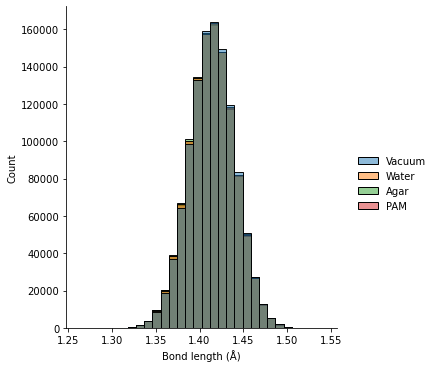

In [141]:
bin_value    = 30
max_value    = max(df.max())
min_value    = min(df.min())
value_range  = max_value-min_value 
interval_num = value_range/bin_value
low          = min_value           
print("Min:", min_value,"Max:", max_value)

point        = []
Vacuum_hist  = [0]
Water_hist   = [0]
Agarose_hist = [0]
PAM_hist     = [0]

for i in range(bin_value):
    high = min_value+interval_num*(i+1)
    Vacuum_num  = df.Vacuum[(df.Vacuum > low) & (df.Vacuum <= high)].count()
    Water_num   = df.Water[(df.Water > low) & (df.Water <= high)].count()
    Agarose_num = df.Agar[(df.Agar > low) & (df.Agar <= high)].count()
    PAM_num     = df.PAM[(df.PAM > low) & (df.PAM <= high)].count()
    if low == min_value:
        Vacuum_num+=1
        Agarose_num+=1
        PAM_num+=1
        Water_num+=1
        point.append(min_value-interval_num/2)
    Vacuum_hist.append(Vacuum_num)
    Water_hist.append(Water_num)
    Agarose_hist.append(Agarose_num)
    PAM_hist.append(PAM_num)
    point.append((low+high)/2)
    low  = high
    
point.append(max_value+interval_num/2)
Vacuum_hist.append(0)
Water_hist.append(0)
Agarose_hist.append(0)
PAM_hist.append(0)

point = pd.DataFrame(point)
Vacuum_hist = pd.DataFrame(Vacuum_hist)
Water_hist = pd.DataFrame(Water_hist)
Agarose_hist = pd.DataFrame(Agarose_hist)
PAM_hist = pd.DataFrame(PAM_hist)

# To CSV
# os.chdir(result_path)
full = pd.concat([point,Vacuum_hist,Water_hist,Agarose_hist,PAM_hist],axis=1)
full.columns = ["Bond Length(A)","Vacuum","Water","Agarose","PAM"]
full.to_csv("hist.csv",index=False)

ax = sns.displot(data=df,kde=False,bins = 30)
ax.set(xlabel="Bond length (Å)", ylabel='Count')

In [143]:
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def fit(name,x,yn,min_v,max_v):
    
    '''
    coeff: 1,10,100,1000,10000
    average: 1.414
    std: 100,10,1,0.1,0.01,0.001,0.0001
    '''

    key_dict = {}
    for l in range(5):
        for k in range(7):
                    std  = 100 / 10**k
                    coeff= 10000 / 10**l

                    try:
                        popt, pcov = curve_fit(func, x, yn, maxfev=1000000,p0=np.array([coeff,1.41,std]))
                    except RuntimeError:
                        continue

                    err1 = popt[1]-1.414

                    if abs(err1)>0.1:
                        continue
                    else:
                        key = str(popt[0])+'_'+str(popt[1])+'_'+str(popt[2])
                        if key not in key_dict.keys():
                            print([popt[0],popt[1],popt[2]])
                            fig = plt.figure()
                            ax = fig.add_subplot(111)
                            x_plt = np.linspace(min_v,max_v,num=500)
                            ax.plot(x, yn, c='k')
                            ax.scatter(x, yn,)
                            print ([coeff,std])
                            key_dict[key] = []
                            ym = func(x_plt, popt[0], popt[1], popt[2])
                            ax.plot(x_plt, ym, c='r', label=name)
                            ax.set_title(name)
                            ax.legend()
                            plt.show()
                            file_name = name+'.png'
                            return x, yn, x_plt, ym , popt[0],popt[1],popt[2]
                            break
                    
                            #     plt.savefig(file_name)    

[164686.176278365, 1.4144315451676988, -0.025803767608515518]
[10000.0, 1.0]


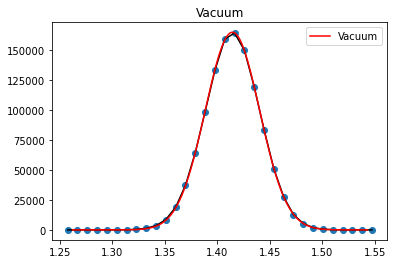

1.26225 0.004610907778579493
1.2628119238476956 0.005241562427734344
1.2633738476953909 0.005955649541840959
1.2639357715430863 0.006763812342230604
1.2644976953907816 0.007677998280002256
1.265059619238477 0.00871161182652268
1.2656215430861724 0.009879684269464877
1.2661834669338679 0.011199062297436366
1.2667453907815631 0.01268861733021899
1.2673073146292586 0.014369477741169536
1.267869238476954 0.016265286324529542
1.2684311623246494 0.018402485584679565
1.2689930861723449 0.02081063366802415
1.2695550100200401 0.023522754022737225
1.2701169338677356 0.02657572215861959
1.2706788577154309 0.03001069319034292
1.2712407815631264 0.033873574184332594
1.2718027054108216 0.038215545694058994
1.2723646292585171 0.04309363726280029
1.2729265531062126 0.04857136209873544
1.2734884769539079 0.05471941658701803
1.2740504008016034 0.06161645079921792
1.2746123246492986 0.06934991669473614
1.2751742484969941 0.07801700128405244
1.2757361723446894 0.08772565264218368
1.2762980961923849 0.0985

In [144]:
x, yn, x_plt, ym,p,pp,ppp = fit('Vacuum',full["Bond Length(A)"],full.Vacuum,min_v=min_value,max_v=max_value)
for i,j in zip(x_plt,ym):
    print(i,j)

[163763.68314075057, 1.414046627929661, -0.025950034501433916]
[10000.0, 1.0]


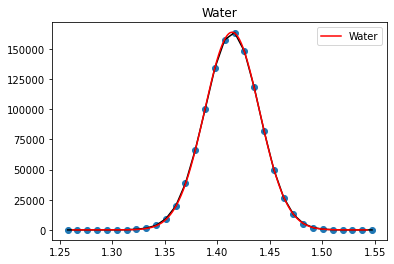

1.26225 0.0060810739989663925
1.2628119238476956 0.006900638481369675
1.2633738476953909 0.0078269871889279
1.2639357715430863 0.008873528124748753
1.2644976953907816 0.010055285294865664
1.265059619238477 0.011389084734332203
1.2656215430861724 0.012893760853267468
1.2661834669338679 0.014590385190299421
1.2667453907815631 0.016502519859899912
1.2673073146292586 0.018656498196489048
1.267869238476954 0.021081735333079412
1.2684311623246494 0.023811071707180675
1.2689930861723449 0.026881152763032434
1.2695550100200401 0.030332848418615742
1.2701169338677356 0.03421171619000838
1.2706788577154309 0.03856851221607457
1.2712407815631264 0.0434597548053234
1.2718027054108216 0.048948345535641556
1.2723646292585171 0.055104253378912664
1.2729265531062126 0.06200526779800307
1.2734884769539079 0.06973782727589195
1.2740504008016034 0.07839793028780008
1.2746123246492986 0.0880921363196831
1.2751742484969941 0.09893866517303081
1.2757361723446894 0.11106860347875364
1.2762980961923849 0.1246

In [145]:
x, yn, x_plt, ym,p,pp,ppp = fit('Water',full["Bond Length(A)"],full.Water,min_v=min_value,max_v=max_value)
for i,j in zip(x_plt,ym):
    print(i,j)

[163614.47753743475, 1.4138202443257628, -0.02598185394099266]
[10000.0, 1.0]


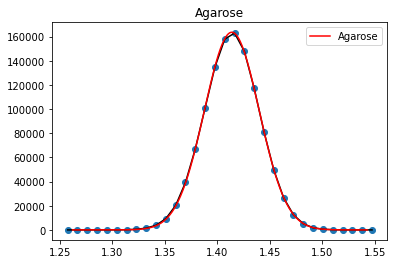

1.26225 0.006665982857875191
1.2628119238476956 0.007560611635517362
1.2633738476953909 0.008571296656266493
1.2639357715430863 0.009712543591619114
1.2644976953907816 0.011000597988297205
1.265059619238477 0.012453644524720999
1.2656215430861724 0.014092027911612149
1.2661834669338679 0.015938497646553702
1.2667453907815631 0.018018479041572357
1.2673073146292586 0.02036037317012432
1.267869238476954 0.022995888626455675
1.2684311623246494 0.025960408257776714
1.2689930861723449 0.029293394319403702
1.2695550100200401 0.033038835816676985
1.2701169338677356 0.0372457421367938
1.2706788577154309 0.041968687440315275
1.2712407815631264 0.04726841067819293
1.2718027054108216 0.05321247652732531
1.2723646292585171 0.05987600299841013
1.2729265531062126 0.06734246196589239
1.2734884769539079 0.07570455940392401
1.2740504008016034 0.08506520268635842
1.2746123246492986 0.0955385629256386
1.2751742484969941 0.10725124098767604
1.2757361723446894 0.12034354652964402
1.2762980961923849 0.13497

In [146]:
x, yn, x_plt, ym,p,pp,ppp = fit('Agarose',full["Bond Length(A)"],full.Agarose,min_v=min_value,max_v=max_value)
for i,j in zip(x_plt,ym):
    print(i,j)

[163355.41464844142, 1.4140348769221704, -0.026006719735181705]
[10000.0, 1.0]


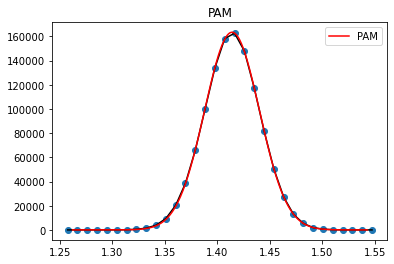

1.26225 0.006552344423737185
1.2628119238476956 0.0074312584001982014
1.2633738476953909 0.008424133766374551
1.2639357715430863 0.009545207910477397
1.2644976953907816 0.010810425227333494
1.265059619238477 0.012237632543738709
1.2656215430861724 0.013846795766226048
1.2661834669338679 0.01566023991768726
1.2667453907815631 0.01770291493442173
1.2673073146292586 0.020002689818042655
1.267869238476954 0.022590677978434948
1.2684311623246494 0.02550159686619506
1.2689930861723449 0.028774165277039836
1.2695550100200401 0.0324515420182127
1.2701169338677356 0.03658180995963791
1.2706788577154309 0.041218509852074196
1.2712407815631264 0.04642122868292258
1.2718027054108216 0.05225624775924416
1.2723646292585171 0.05879725615940067
1.2729265531062126 0.06612613568121649
1.2734884769539079 0.07433382393840975
1.2740504008016034 0.08352126282015507
1.2746123246492986 0.09380044013368574
1.2751742484969941 0.10529553289947864
1.2757361723446894 0.11814416146491062
1.2762980961923849 0.132498

In [147]:
x, yn, x_plt, ym,p,pp,ppp = fit('PAM',full["Bond Length(A)"],full.PAM,min_v=min_value,max_v=max_value)
for i,j in zip(x_plt,ym):
    print(i,j)

In [ ]:
# If poly around?

In [149]:
def get_bond_list(p,last,ps_length=499):
    poly_bond     = []
    not_poly_bond = []
    os.chdir(p)
    largest = -1
    
    for file in os.listdir("./dump"):
        frame = int(file.split(".")[-1])
        if frame > largest:
            largest = frame
    
    Select_start_ps = int(last-ps_length)
    Select_end_ps   = int(last) 
    
    bond_dict = {}
    
    poly_type_file = "Atom_type_1_6.data"
    polylist_large = []
    temp_list = []
    last_frame = -1
    
    
    with open(poly_type_file,'r') as f:
        for line in f.readlines():
            if 'frame' in line:
                continue
            frame  = line.split()[0]
            serial = int(line.split()[1])
            flag   = int(line.split()[2])
            if last_frame != frame:
                temp_list = []
                polylist_large.append(temp_list)
                last_frame = frame
            if flag == 1:
                temp_list.append(serial)  
#     print(polylist_large[0])    
    
    
    for i in range(Select_end_ps-Select_start_ps+1):    
        num  = Select_start_ps*1000+i*1000
        file = "./dump/dump."+str(num)
        record = False
#         print(i)
#         print(file,"\n")
        polylist = polylist_large[i]
        
        with open(file,'r') as f:
            for line in f.readlines():
                polyon     = False
                small_atom = 0
                big_atom   = 0
                count = 0
                if record:
                    temp_list = line.split(" ")
                    atom1 = int(temp_list[0])
                    atom2 = int(temp_list[1])
                    if atom1 in polylist:
                        polyon = True
                    if atom2 in polylist:
                        polyon = True
                    bond_type = int(temp_list[2])
                    bond_length = float(temp_list[4])
                    if bond_type == 1:

#                         print(bond_length)
                        if polyon:
                            poly_bond.append(bond_length)
                        else:
                            not_poly_bond.append(bond_length)
                            
#                         count += 1
#                         if atom1 < atom2:
#                             small_atom = atom1
#                             big_atom   = atom2
#                         else:
#                             small_atom = atom2
#                             big_atom   = atom1

    #                     print(atom1,atom2)
#                         key = str(atom1)+"_"+str(atom2)
#                         if i == 0:
#                             bond_dict[key] = [bond_length]
#                         else:
#                             bond_dict[key].append(bond_length)
                            
                if "c_1[1]" in line:
                    record = True
    return poly_bond,not_poly_bond
                    

In [150]:
Name = "Agarose"
Agar_poly,Agar_not_poly = get_bond_list(Agar_path,last=998)
all_list = Agar_poly+Agar_not_poly
min_v=min(all_list)
max_v=max(all_list)

In [151]:
print(len(Agar_poly),len(Agar_not_poly),len(Agar_poly)+len(Agar_not_poly))
print(np.mean(Agar_poly),np.mean(Agar_not_poly),np.mean(all_list))
print(np.std(Agar_poly),np.std(Agar_not_poly))

495445 645555 1141000
1.4142389016338852 1.4131726523998736 1.4136356391235758
0.025536560642297944 0.026225723579317205


[71971.46687099035, 1.4142749006480364, 0.025665430782829533]
[10000.0, 1.0]


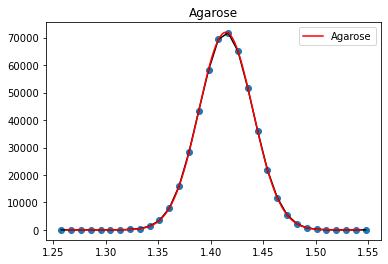

1.2575766666666668 0
1.2669233333333334 0
1.27627 0
1.2856166666666669 3
1.2949633333333335 1
1.30431 15
1.3136566666666667 43
1.3230033333333333 172
1.3323500000000001 468
1.3416966666666668 1362
1.3510433333333334 3441
1.3603900000000002 7911
1.3697366666666668 15992
1.3790833333333334 28265
1.38843 43374
1.3977766666666667 58209
1.4071233333333333 69396
1.4164700000000001 71783
1.4258166666666667 65033
1.4351633333333336 51633
1.4445100000000002 36011
1.4538566666666668 21824
1.4632033333333334 11744
1.47255 5462
1.4818966666666666 2225
1.4912433333333335 741
1.50059 248
1.5099366666666667 68
1.5192833333333335 17
1.5286300000000002 4
1.5379766666666668 0
1.5473233333333334 0

1.26225 0.001731246470091422
1.2628119238476956 0.0019705024591376475
1.2633738476953909 0.002241748459437786
1.2639357715430863 0.002549110120816058
1.2644976953907816 0.002897224393053513
1.265059619238477 0.0032913001333270808
1.2656215430861724 0.003737185543278987
1.2661834669338679 0.004241443161349829
1

In [152]:
x, yn, x_plt, ym,p,pp,ppp = fit('Agarose',distribution(Agar_poly,min_value=min_value,max_value=max_value,bin_value=30)[0],distribution(Agar_poly,min_value=min_value,max_value=max_value,bin_value=30)[1],min_v=min_value,max_v=max_value)
for i,j in zip(x,yn):
    print(i,j)
print()
for i,j in zip(x_plt,ym):
    print(i,j)

[91661.71759317124, 1.4134568343149798, 0.026229365463840634]
[10000.0, 1.0]


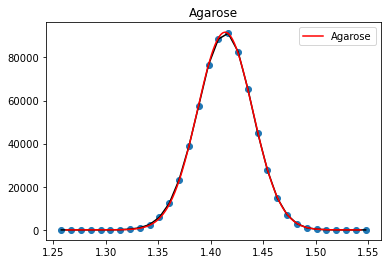

1.2575766666666668 0
1.2669233333333334 0
1.27627 1
1.2856166666666669 2
1.2949633333333335 10
1.30431 39
1.3136566666666667 123
1.3230033333333333 349
1.3323500000000001 997
1.3416966666666668 2495
1.3510433333333334 5892
1.3603900000000002 12358
1.3697366666666668 23303
1.3790833333333334 38817
1.38843 57690
1.3977766666666667 76618
1.4071233333333333 88508
1.4164700000000001 91162
1.4258166666666667 82710
1.4351633333333336 65450
1.4445100000000002 45143
1.4538566666666668 27677
1.4632033333333334 14780
1.47255 7037
1.4818966666666666 2905
1.4912433333333335 1020
1.50059 335
1.5099366666666667 99
1.5192833333333335 28
1.5286300000000002 5
1.5379766666666668 2
1.5473233333333334 0

1.26225 0.005568926944652541
1.2628119238476956 0.006299528013339364
1.2633738476953909 0.0071227085902614415
1.2639357715430863 0.008049761545173893
1.2644976953907816 0.00909330020091996
1.265059619238477 0.010267405544691162
1.2656215430861724 0.011587788976661932
1.2661834669338679 0.013071972133332999

In [153]:
x, yn, x_plt, ym,p,pp,ppp = fit('Agarose',distribution(Agar_not_poly,min_value=min_value,max_value=max_value,bin_value=30)[0],distribution(Agar_not_poly,min_value=min_value,max_value=max_value,bin_value=30)[1],min_v=min_value,max_v=max_value)
for i,j in zip(x,yn):
    print(i,j)
print()
for i,j in zip(x_plt,ym):
    print(i,j)

In [154]:
Name = "PAM"
Agar_poly,Agar_not_poly = get_bond_list(PAM_path,last=998)
all_list = Agar_poly+Agar_not_poly

In [155]:
print(len(Agar_poly),len(Agar_not_poly),len(Agar_poly)+len(Agar_not_poly))
print(np.mean(Agar_poly),np.mean(Agar_not_poly),np.mean(all_list))
print(np.std(Agar_poly),np.std(Agar_not_poly))

556840 584160 1141000
1.4143682664499675 1.4133927789133114 1.413868844189308
0.02576763125303467 0.026223345415883743


[80397.81982610426, 1.4144626304031531, 0.025792943763333916]
[10000.0, 1.0]


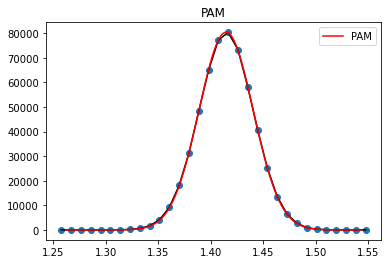

1.2575766666666668 0
1.2669233333333334 1
1.27627 1
1.2856166666666669 0
1.2949633333333335 2
1.30431 24
1.3136566666666667 55
1.3230033333333333 190
1.3323500000000001 621
1.3416966666666668 1651
1.3510433333333334 4135
1.3603900000000002 9134
1.3697366666666668 18082
1.3790833333333334 31283
1.38843 48241
1.3977766666666667 64926
1.4071233333333333 77242
1.4164700000000001 80326
1.4258166666666667 73272
1.4351633333333336 58034
1.4445100000000002 40624
1.4538566666666668 25035
1.4632033333333334 13522
1.47255 6428
1.4818966666666666 2677
1.4912433333333335 935
1.50059 297
1.5099366666666667 81
1.5192833333333335 18
1.5286300000000002 2
1.5379766666666668 1
1.5473233333333334 0

1.26225 0.00220264615938267
1.2628119238476956 0.0025042472307381398
1.2633738476953909 0.002845794528138227
1.2639357715430863 0.003232389963081553
1.2644976953907816 0.0036697614225722763
1.265059619238477 0.004164336199134665
1.2656215430861724 0.004723322605131121
1.2661834669338679 0.005354800630840973
1.

In [156]:
x, yn, x_plt, ym,p,pp,ppp = fit('PAM',distribution(Agar_poly,min_value=min_value,max_value=max_value,bin_value=30)[0],distribution(Agar_poly,min_value=min_value,max_value=max_value,bin_value=30)[1],min_v=min_value,max_v=max_value)
for i,j in zip(x,yn):
    print(i,j)
print()
for i,j in zip(x_plt,ym):
    print(i,j)

[82980.6129995718, 1.4136164641845017, -0.026208599039311106]
[10000.0, 1.0]


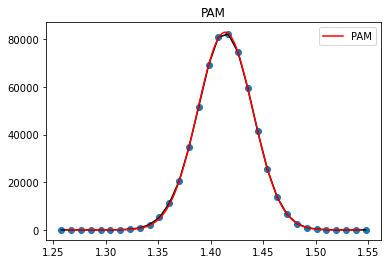

1.2575766666666668 0
1.2669233333333334 0
1.27627 2
1.2856166666666669 0
1.2949633333333335 9
1.30431 33
1.3136566666666667 95
1.3230033333333333 314
1.3323500000000001 835
1.3416966666666668 2242
1.3510433333333334 5250
1.3603900000000002 11186
1.3697366666666668 20526
1.3790833333333334 34636
1.38843 51798
1.3977766666666667 69076
1.4071233333333333 80905
1.4164700000000001 82238
1.4258166666666667 74546
1.4351633333333336 59406
1.4445100000000002 41393
1.4538566666666668 25386
1.4632033333333334 13679
1.47255 6485
1.4818966666666666 2692
1.4912433333333335 973
1.50059 318
1.5099366666666667 98
1.5192833333333335 29
1.5286300000000002 8
1.5379766666666668 1
1.5473233333333334 0

1.26225 0.004740790126199936
1.2628119238476956 0.005364494535916783
1.2633738476953909 0.00606746448670396
1.2639357715430863 0.006859398544811004
1.2644976953907816 0.007751133001840424
1.265059619238477 0.00875476915640131
1.2656215430861724 0.009883814080556566
1.2661834669338679 0.011153336210929203
1.26

In [157]:
x, yn, x_plt, ym,p,pp,ppp = fit('PAM',distribution(Agar_not_poly,min_value=min_value,max_value=max_value,bin_value=30)[0],distribution(Agar_not_poly,min_value=min_value,max_value=max_value,bin_value=30)[1],min_v=min_value,max_v=max_value)
for i,j in zip(x,yn):
    print(i,j)
print()
for i,j in zip(x_plt,ym):
    print(i,j)

In [ ]:
# <=1.41?

In [158]:
def smaller_than(p,last,ps_length=499):
    small_bond     = []
    large_bond     = []
    small_poly     = []
    small_not_poly = []
    large_poly     = []
    large_not_poly = []
    os.chdir(p)
    largest = -1
    
    for file in os.listdir("./dump"):
        frame = int(file.split(".")[-1])
        if frame > largest:
            largest = frame
    
    Select_start_ps = int(last-ps_length)
    Select_end_ps   = int(last) 
    
    bond_dict = {}
    
    poly_type_file = "Atom_type_1_6.data"
    polylist_large = []
    temp_list = []
    last_frame = -1
    
    with open(poly_type_file,'r') as f:
        for line in f.readlines():
            if 'frame' in line:
                continue
            frame  = line.split()[0]
            serial = int(line.split()[1])
            flag   = int(line.split()[2])
            if last_frame != frame:
                temp_list = []
                polylist_large.append(temp_list)
                last_frame = frame
            if flag == 1:
                temp_list.append(serial)  
#     print(polylist_large[0])    

    for i in range(Select_end_ps-Select_start_ps+1):    
        num  = Select_start_ps*1000+i*1000
        file = "./dump/dump."+str(num)
        record = False
#         print(i)
#         print(file,"\n")
        polylist = polylist_large[i]
        with open(file,'r') as f:
            for line in f.readlines():
                polyon     = False
                if record:
                    temp_list = line.split(" ")
                    atom1 = int(temp_list[0])
                    atom2 = int(temp_list[1])
                    if atom1 in polylist:
                        polyon = True
                    if atom2 in polylist:
                        polyon = True
                    bond_type = int(temp_list[2])
                    bond_length = float(temp_list[4])
                    if bond_type == 1:
                        if bond_length<=1.41:
                            small_bond.append(bond_length)
                            if polyon:
                                small_poly.append(bond_length)
                            else:
                                small_not_poly.append(bond_length)
                            
                        else:
                            large_bond.append(bond_length)
                            if polyon:
                                large_poly.append(bond_length)
                            else:
                                large_not_poly.append(bond_length)
                if "c_1[1]" in line:
                    record = True
    return small_bond,large_bond,small_poly,small_not_poly,large_poly,large_not_poly

In [161]:
small,big,sp,snp,lp,lnp = smaller_than(Agar_path,last=998)
Name = "Agarose_<1.41"
all_list = Agar_poly+Agar_not_poly
min_v=min(all_list)
max_v=max(all_list)

print(len(sp),len(snp),len(lp),len(lnp),len(sp+snp+lp+lnp))
print(np.mean(sp),np.mean(snp),np.mean(lp),np.mean(lnp),np.mean(sp+snp+lp+lnp))
print(np.std(sp),np.std(snp),np.std(lp),np.std(lnp),np.std(sp+snp+lp+lnp))

214867 289751 280578 355804 1141000
1.3910790054778068 1.3900683330169699 1.431974780453207 1.4319877855785768 1.4136356391235763
0.014713599000574767 0.015515587527092513 0.016136800524258164 0.01622129344529162 0.025934110805662693


In [162]:
small,big,sp,snp,lp,lnp = smaller_than(PAM_path,last=998)
Name = "Agarose_<1.41"
all_list = Agar_poly+Agar_not_poly
min_v=min(all_list)
max_v=max(all_list)

print(len(sp),len(snp),len(lp),len(lnp),len(sp+snp+lp+lnp))
print(np.mean(sp),np.mean(snp),np.mean(lp),np.mean(lnp),np.mean(sp+snp+lp+lnp))
print(np.std(sp),np.std(snp),np.std(lp),np.std(lnp),np.std(sp+snp+lp+lnp))

240123 260856 316717 323304 1141000
1.3909047032562478 1.390210231468703 1.4321574636978753 1.4320974859265583 1.4138688441893066
0.014906382445408053 0.015470189450218861 0.01628039568262589 0.016306846938731842 0.026006513453389897


In [81]:
# Average

In [166]:
def get_bond_list(p,last,ps_length=499):
    
    os.chdir(p)
    largest = -1
    
    for file in os.listdir("./dump"):
        frame = int(file.split(".")[-1])
        if frame > largest:
            largest = frame
    
    Select_start_ps = int(last-ps_length)
    Select_end_ps   = int(last)   
    
    bond_dict = {}
    for i in range(Select_end_ps-Select_start_ps+1):    
        num  = Select_start_ps*1000+i*1000
        file = "./dump/dump."+str(num)
        record = False
        #print(file)
        with open(file,'r') as f:
            for line in f.readlines():
                small_atom = 0
                big_atom   = 0
                count = 0
                if record:
                    temp_list = line.split(" ")
                    atom1 = int(temp_list[0])
                    atom2 = int(temp_list[1])
                    bond_type = int(temp_list[2])
                    bond_length = float(temp_list[4])
                    if bond_type == 1:

                        count += 1
                        if atom1 < atom2:
                            small_atom = atom1
                            big_atom   = atom2
                        else:
                            small_atom = atom2
                            big_atom   = atom1

    #                     print(atom1,atom2)
                        key = str(atom1)+"_"+str(atom2)
                        if i == 0:
                            bond_dict[key] = [bond_length]
                        else:
                            bond_dict[key].append(bond_length)
                if "c_1[1]" in line:
                    record = True      
    #         break
    mean_dict = {}
    full_list = []
    for key in bond_dict.keys():
        mean_dict[key] = np.mean(np.array(bond_dict[key]))
        full_list.append(np.mean(np.array(bond_dict[key])))
    print("Average:",np.mean(np.array(full_list)),np.std(np.array(full_list)))
    print("Min max:",np.array(full_list).min(),np.array(full_list).max())
    print("Length:",len(full_list))
    return bond_dict, pd.DataFrame(full_list)


In [167]:
print("Vacuum")
Vacuum_dict, Vacuum_df = get_bond_list(Vacuum_path,last=1000)
Vacuum_df.columns = ["Water"]
print("\nWater")
Water_dict, Water_df = get_bond_list(Water_path,last=2100)
Water_df.columns = ["Water"]
print("\nAgarose")
Agarose_dict, Agarose_df = get_bond_list(Agar_path,last=998)
Agarose_df.columns = ["Agarose"]
print("\nPAM")
PAM_dict, PAM_df = get_bond_list(PAM_path,last=998)
PAM_df.columns = ["PAM"]

Vacuum
Average: 1.414267616520596 0.004741521186402221
Min max: 1.38140164 1.4307388
Length: 2282

Water
Average: 1.4138701431288345 0.0048147402047897065
Min max: 1.3801641399999998 1.4287060200000001
Length: 2282

Agarose
Average: 1.4136356391235758 0.00481568849539801
Min max: 1.38087496 1.4281279399999998
Length: 2282

PAM
Average: 1.4138688441893077 0.004821098765292327
Min max: 1.38222442 1.4291438600000002
Length: 2282


In [129]:
Agarose_dict["818_819"]

[1.41578,
 1.42782,
 1.4099,
 1.43454,
 1.43731,
 1.45052,
 1.41745,
 1.37248,
 1.49205,
 1.41972,
 1.43124,
 1.40399,
 1.42188,
 1.38873,
 1.3953,
 1.41232,
 1.38355,
 1.43625,
 1.43629,
 1.40571,
 1.36876,
 1.40721,
 1.40541,
 1.40713,
 1.39245,
 1.41645,
 1.3778,
 1.39711,
 1.40308,
 1.45913,
 1.45329,
 1.40839,
 1.40632,
 1.42998,
 1.43753,
 1.40741,
 1.43763,
 1.41973,
 1.43839,
 1.44603,
 1.38022,
 1.40358,
 1.43625,
 1.36325,
 1.41932,
 1.41136,
 1.44874,
 1.37025,
 1.42641,
 1.4125,
 1.40469,
 1.40555,
 1.44115,
 1.34666,
 1.44356,
 1.43932,
 1.43752,
 1.45137,
 1.42449,
 1.38401,
 1.43803,
 1.41744,
 1.43993,
 1.38759,
 1.40515,
 1.41617,
 1.42542,
 1.44858,
 1.39808,
 1.39116,
 1.43038,
 1.42978,
 1.41684,
 1.44831,
 1.39234,
 1.42506,
 1.39613,
 1.39567,
 1.40355,
 1.43779,
 1.42548,
 1.3947,
 1.38994,
 1.38976,
 1.41321,
 1.46894,
 1.44409,
 1.41255,
 1.4432,
 1.4069,
 1.40308,
 1.3822,
 1.44639,
 1.43003,
 1.443,
 1.42858,
 1.39267,
 1.37634,
 1.41946,
 1.37399,
 1.39483,


In [ ]:
# Atom type analysis example

In [168]:
def get_index(input_list):
    return [index for (index,value) in enumerate(input_list) if value > 0]

def type_classify(p,bond_dict):
    print(p)
    os.chdir(p)
    atom_type = pd.read_csv("Atom_type_2500_2999.data",sep=" ",index_col=False)
    out_dict = {}
    original_column = list(atom_type.columns[2:])
    column = sorted(list(atom_type.columns[2:]))
    
    for i in range(len(column)):
        temp_comb = combinations(column,i)
        for i in list(temp_comb):
            out_dict[i[:]] = []
            
    temp_comb = combinations(column,len(column))
    for i in list(temp_comb):
        out_dict[i[:]] = []
        
    for key in bond_dict.keys():
        print(key)
        atom_1 = int(key.split("_")[0])
        atom_2 = int(key.split("_")[1])
#         print(atom_1,atom_2)
        for i in range(len(bond_dict[key])):
#             print(bond_dict[key][i])
            # atom type中的0 > 對應到dict中的0 > 對應到真實時間的2501 > 對應到 load dcd first 4502 last 5002 中的0
            frame = i
            a = (np.array(atom_type[(atom_type.frame==frame) & (atom_type.serial == atom_1)])[0]+\
                 np.array(atom_type[(atom_type.frame==frame) & (atom_type.serial == atom_2)])[0])[2:]
#             print(a)
#             print(get_index(a))
            temp = sorted([original_column[k] for k in get_index(a)])
            temp_comb = list(combinations(temp,len(temp)))[0]
#             print(temp_comb)
            out_dict[temp_comb].append(bond_dict[key][i])
#         print("\n")
    
    with open("atom_type_1_6.csv",'w',newline='') as f:
        writer = csv.writer(f)
        for temp_key, temp_value in out_dict.items():
            writer.writerow([temp_key,temp_value])
    return out_dict
agar_type_dict = type_classify(Agar_path,Agarose_dict)

..\Agar


C:\Users\QAQ\AppData\Local\Temp\ipykernel_6556\867006149.py:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  atom_type = pd.read_csv("Atom_type_2500_2999.data",sep=" ",index_col=False)


1012_1013
1012_1133
1011_1012
1010_1011
1010_1015
1013_1014
1013_1140
1015_1016
889_890
889_1016
1014_1015
1006_1007
1006_1011
1005_1006
1005_1132
1133_1134
1139_1140
1132_1133
1134_1135
1134_1139
1138_1139
1131_1132
1135_1136
1130_1131
1130_1135
1136_1137
1136_1257
1129_1130
1129_1256
1257_1258
1256_1257
1255_1256
1137_1138
1137_1264
1258_1259
1258_1263
1254_1255
1254_1259
1253_1254
1253_1380
1259_1260
1263_1264
1380_1381
1260_1261
1260_1381
890_891
763_764
1009_1010
888_889
888_1009
1007_1008
758_759
758_763
1008_1009
891_892
884_885
878_879
878_883
1002_1003
1002_1007
880_881
880_1001
881_882
881_1008
879_880
882_883
882_887
887_888
883_884
877_878
886_887
886_891
885_886
756_757
756_877
757_758
757_884
755_756
764_765
764_885
765_766
765_892
759_760
1001_1002
1004_1005
1004_1125
754_755
754_759
753_754
762_763
762_767
766_767
1126_1127
1126_1131
151_152
6_7
5_6
5_13
1_2
1_6
2_3
3_4
3_151
4_5
4_158
702_703
702_707
946_947
946_951
951_952
835_836
836_837
937_938
938_939
938_943
1085_

1274_1277
1278_1279
1278_1283
1156_1157
1156_1277
1407_1408
1281_1282
1281_1408
1174_1175
1174_1179
1283_1284
1408_1409
1286_1287
1286_1291
1158_1159
1158_1163
1291_1292
1558_1559
1558_1563
1559_1560
1552_1553
1552_1559
1049_1050
1049_1176
1428_1429
1428_1557
1557_1558
1298_1299
1298_1303
1299_1300
1410_1411
1410_1415
1424_1425
1297_1298
1297_1424
1421_1422
1421_1554
1553_1554
1296_1297
1296_1417
1418_1419
1418_1423
1417_1418
1548_1549
1548_1553
1547_1548
1414_1415
1414_1419
1544_1547
1537_1538
1411_1412
1412_1413
1412_1537
1415_1416
1413_1414
1413_1544
1419_1420
1420_1421
1420_1547
1554_1557
1423_1424
1422_1423
1422_1427
1416_1417
1427_1428
1425_1426
1175_1176
1292_1293
1282_1283
1282_1287
1046_1047
1046_1051
1173_1174
1173_1300
1048_1049
1048_1169
1042_1043
1042_1047
1161_1162
1169_1170
1171_1172
1168_1169
1166_1167
1166_1171
1041_1042
1041_1168
1162_1163
1162_1167
1167_1168
1170_1171
1170_1175
1047_1048
1159_1160
1285_1286
1163_1164
1294_1295
1294_1299
1157_1158
1157_1284
1288_1289


510_515
516_517
516_637
507_508
509_510
509_636
502_503
502_507
508_509
508_629
636_637
629_630
635_636
630_631
630_635
631_632
517_518
517_644
519_520
518_519
146_147
271_272
388_389
267_268
143_144
382_383
382_387
132_133
132_137
133_134
134_135
134_257
257_258
256_257
255_256
259_260
254_255
254_259
260_261
260_381
380_381
381_382
261_262
261_388
258_259
258_263
262_263
262_267
263_264
125_126
125_256
135_136
135_264
126_127
126_133
264_265
136_137
136_143
265_266
266_267
266_271
144_145
144_265
145_146
145_272
137_138
127_128
383_384
378_379
378_383
628_629
253_254
253_380
7_11
11_12
12_13
12_17
480_481
364_365
367_368
496_497
479_480
478_479
478_483
377_378
377_504
626_627
626_631
488_489
369_370
369_496
361_362
361_488
501_502
501_628
627_628
621_622
623_624
619_620
620_621
622_623
622_627
500_501
500_621
247_248
503_504
124_125
124_249
249_250
251_252
373_374
246_247
246_251
244_245
244_365
245_246
245_372
252_253
252_373
250_251
250_255
370_371
370_375
614_615
614_619
368_369
3

In [170]:
key_list = []
for key in agar_type_dict.keys():
#     print(key,len(agar_type_dict[key]))
    if len(agar_type_dict[key])!=0:
        key_list.append(key)
len(key_list)

303

In [171]:
count = 0
for key in agar_type_dict.keys():
    print(key)
    temp_list = pd.DataFrame(agar_type_dict[key])
    if count == 0:
        df_temp = temp_list
    else:
        df_temp = pd.concat([df_temp,temp_list],axis=1, ignore_index=True)
    count+=1

()
('Ceth',)
('Chyd',)
('H2O',)
('Hchyd',)
('Heth',)
('Hhyd',)
('Obr',)
('Ohyd',)
('Oor',)
('Or',)
('dH2O',)
('Ceth', 'Chyd')
('Ceth', 'H2O')
('Ceth', 'Hchyd')
('Ceth', 'Heth')
('Ceth', 'Hhyd')
('Ceth', 'Obr')
('Ceth', 'Ohyd')
('Ceth', 'Oor')
('Ceth', 'Or')
('Ceth', 'dH2O')
('Chyd', 'H2O')
('Chyd', 'Hchyd')
('Chyd', 'Heth')
('Chyd', 'Hhyd')
('Chyd', 'Obr')
('Chyd', 'Ohyd')
('Chyd', 'Oor')
('Chyd', 'Or')
('Chyd', 'dH2O')
('H2O', 'Hchyd')
('H2O', 'Heth')
('H2O', 'Hhyd')
('H2O', 'Obr')
('H2O', 'Ohyd')
('H2O', 'Oor')
('H2O', 'Or')
('H2O', 'dH2O')
('Hchyd', 'Heth')
('Hchyd', 'Hhyd')
('Hchyd', 'Obr')
('Hchyd', 'Ohyd')
('Hchyd', 'Oor')
('Hchyd', 'Or')
('Hchyd', 'dH2O')
('Heth', 'Hhyd')
('Heth', 'Obr')
('Heth', 'Ohyd')
('Heth', 'Oor')
('Heth', 'Or')
('Heth', 'dH2O')
('Hhyd', 'Obr')
('Hhyd', 'Ohyd')
('Hhyd', 'Oor')
('Hhyd', 'Or')
('Hhyd', 'dH2O')
('Obr', 'Ohyd')
('Obr', 'Oor')
('Obr', 'Or')
('Obr', 'dH2O')
('Ohyd', 'Oor')
('Ohyd', 'Or')
('Ohyd', 'dH2O')
('Oor', 'Or')
('Oor', 'dH2O')
('Or', 'dH2

('Ceth', 'Hhyd', 'Ohyd', 'Oor')
('Ceth', 'Hhyd', 'Ohyd', 'Or')
('Ceth', 'Hhyd', 'Ohyd', 'dH2O')
('Ceth', 'Hhyd', 'Oor', 'Or')
('Ceth', 'Hhyd', 'Oor', 'dH2O')
('Ceth', 'Hhyd', 'Or', 'dH2O')
('Ceth', 'Obr', 'Ohyd', 'Oor')
('Ceth', 'Obr', 'Ohyd', 'Or')
('Ceth', 'Obr', 'Ohyd', 'dH2O')
('Ceth', 'Obr', 'Oor', 'Or')
('Ceth', 'Obr', 'Oor', 'dH2O')
('Ceth', 'Obr', 'Or', 'dH2O')
('Ceth', 'Ohyd', 'Oor', 'Or')
('Ceth', 'Ohyd', 'Oor', 'dH2O')
('Ceth', 'Ohyd', 'Or', 'dH2O')
('Ceth', 'Oor', 'Or', 'dH2O')
('Chyd', 'H2O', 'Hchyd', 'Heth')
('Chyd', 'H2O', 'Hchyd', 'Hhyd')
('Chyd', 'H2O', 'Hchyd', 'Obr')
('Chyd', 'H2O', 'Hchyd', 'Ohyd')
('Chyd', 'H2O', 'Hchyd', 'Oor')
('Chyd', 'H2O', 'Hchyd', 'Or')
('Chyd', 'H2O', 'Hchyd', 'dH2O')
('Chyd', 'H2O', 'Heth', 'Hhyd')
('Chyd', 'H2O', 'Heth', 'Obr')
('Chyd', 'H2O', 'Heth', 'Ohyd')
('Chyd', 'H2O', 'Heth', 'Oor')
('Chyd', 'H2O', 'Heth', 'Or')
('Chyd', 'H2O', 'Heth', 'dH2O')
('Chyd', 'H2O', 'Hhyd', 'Obr')
('Chyd', 'H2O', 'Hhyd', 'Ohyd')
('Chyd', 'H2O', 'Hhyd', 'Oo

('Ceth', 'Chyd', 'Hchyd', 'Heth', 'Obr')
('Ceth', 'Chyd', 'Hchyd', 'Heth', 'Ohyd')
('Ceth', 'Chyd', 'Hchyd', 'Heth', 'Oor')
('Ceth', 'Chyd', 'Hchyd', 'Heth', 'Or')
('Ceth', 'Chyd', 'Hchyd', 'Heth', 'dH2O')
('Ceth', 'Chyd', 'Hchyd', 'Hhyd', 'Obr')
('Ceth', 'Chyd', 'Hchyd', 'Hhyd', 'Ohyd')
('Ceth', 'Chyd', 'Hchyd', 'Hhyd', 'Oor')
('Ceth', 'Chyd', 'Hchyd', 'Hhyd', 'Or')
('Ceth', 'Chyd', 'Hchyd', 'Hhyd', 'dH2O')
('Ceth', 'Chyd', 'Hchyd', 'Obr', 'Ohyd')
('Ceth', 'Chyd', 'Hchyd', 'Obr', 'Oor')
('Ceth', 'Chyd', 'Hchyd', 'Obr', 'Or')
('Ceth', 'Chyd', 'Hchyd', 'Obr', 'dH2O')
('Ceth', 'Chyd', 'Hchyd', 'Ohyd', 'Oor')
('Ceth', 'Chyd', 'Hchyd', 'Ohyd', 'Or')
('Ceth', 'Chyd', 'Hchyd', 'Ohyd', 'dH2O')
('Ceth', 'Chyd', 'Hchyd', 'Oor', 'Or')
('Ceth', 'Chyd', 'Hchyd', 'Oor', 'dH2O')
('Ceth', 'Chyd', 'Hchyd', 'Or', 'dH2O')
('Ceth', 'Chyd', 'Heth', 'Hhyd', 'Obr')
('Ceth', 'Chyd', 'Heth', 'Hhyd', 'Ohyd')
('Ceth', 'Chyd', 'Heth', 'Hhyd', 'Oor')
('Ceth', 'Chyd', 'Heth', 'Hhyd', 'Or')
('Ceth', 'Chyd', 'Heth',

('Chyd', 'H2O', 'Heth', 'Obr', 'Oor')
('Chyd', 'H2O', 'Heth', 'Obr', 'Or')
('Chyd', 'H2O', 'Heth', 'Obr', 'dH2O')
('Chyd', 'H2O', 'Heth', 'Ohyd', 'Oor')
('Chyd', 'H2O', 'Heth', 'Ohyd', 'Or')
('Chyd', 'H2O', 'Heth', 'Ohyd', 'dH2O')
('Chyd', 'H2O', 'Heth', 'Oor', 'Or')
('Chyd', 'H2O', 'Heth', 'Oor', 'dH2O')
('Chyd', 'H2O', 'Heth', 'Or', 'dH2O')
('Chyd', 'H2O', 'Hhyd', 'Obr', 'Ohyd')
('Chyd', 'H2O', 'Hhyd', 'Obr', 'Oor')
('Chyd', 'H2O', 'Hhyd', 'Obr', 'Or')
('Chyd', 'H2O', 'Hhyd', 'Obr', 'dH2O')
('Chyd', 'H2O', 'Hhyd', 'Ohyd', 'Oor')
('Chyd', 'H2O', 'Hhyd', 'Ohyd', 'Or')
('Chyd', 'H2O', 'Hhyd', 'Ohyd', 'dH2O')
('Chyd', 'H2O', 'Hhyd', 'Oor', 'Or')
('Chyd', 'H2O', 'Hhyd', 'Oor', 'dH2O')
('Chyd', 'H2O', 'Hhyd', 'Or', 'dH2O')
('Chyd', 'H2O', 'Obr', 'Ohyd', 'Oor')
('Chyd', 'H2O', 'Obr', 'Ohyd', 'Or')
('Chyd', 'H2O', 'Obr', 'Ohyd', 'dH2O')
('Chyd', 'H2O', 'Obr', 'Oor', 'Or')
('Chyd', 'H2O', 'Obr', 'Oor', 'dH2O')
('Chyd', 'H2O', 'Obr', 'Or', 'dH2O')
('Chyd', 'H2O', 'Ohyd', 'Oor', 'Or')
('Chyd', 

('Heth', 'Hhyd', 'Ohyd', 'Or', 'dH2O')
('Heth', 'Hhyd', 'Oor', 'Or', 'dH2O')
('Heth', 'Obr', 'Ohyd', 'Oor', 'Or')
('Heth', 'Obr', 'Ohyd', 'Oor', 'dH2O')
('Heth', 'Obr', 'Ohyd', 'Or', 'dH2O')
('Heth', 'Obr', 'Oor', 'Or', 'dH2O')
('Heth', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Hhyd', 'Obr', 'Ohyd', 'Oor', 'Or')
('Hhyd', 'Obr', 'Ohyd', 'Oor', 'dH2O')
('Hhyd', 'Obr', 'Ohyd', 'Or', 'dH2O')
('Hhyd', 'Obr', 'Oor', 'Or', 'dH2O')
('Hhyd', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Obr', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Heth', 'Hhyd')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Heth', 'Obr')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Heth', 'Ohyd')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Heth', 'Oor')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Heth', 'Or')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Heth', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Obr')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Ohyd')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Oor')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Or')
('Ceth', 'Chyd', 'H2O', 'H

('Ceth', 'H2O', 'Heth', 'Hhyd', 'Obr', 'dH2O')
('Ceth', 'H2O', 'Heth', 'Hhyd', 'Ohyd', 'Oor')
('Ceth', 'H2O', 'Heth', 'Hhyd', 'Ohyd', 'Or')
('Ceth', 'H2O', 'Heth', 'Hhyd', 'Ohyd', 'dH2O')
('Ceth', 'H2O', 'Heth', 'Hhyd', 'Oor', 'Or')
('Ceth', 'H2O', 'Heth', 'Hhyd', 'Oor', 'dH2O')
('Ceth', 'H2O', 'Heth', 'Hhyd', 'Or', 'dH2O')
('Ceth', 'H2O', 'Heth', 'Obr', 'Ohyd', 'Oor')
('Ceth', 'H2O', 'Heth', 'Obr', 'Ohyd', 'Or')
('Ceth', 'H2O', 'Heth', 'Obr', 'Ohyd', 'dH2O')
('Ceth', 'H2O', 'Heth', 'Obr', 'Oor', 'Or')
('Ceth', 'H2O', 'Heth', 'Obr', 'Oor', 'dH2O')
('Ceth', 'H2O', 'Heth', 'Obr', 'Or', 'dH2O')
('Ceth', 'H2O', 'Heth', 'Ohyd', 'Oor', 'Or')
('Ceth', 'H2O', 'Heth', 'Ohyd', 'Oor', 'dH2O')
('Ceth', 'H2O', 'Heth', 'Ohyd', 'Or', 'dH2O')
('Ceth', 'H2O', 'Heth', 'Oor', 'Or', 'dH2O')
('Ceth', 'H2O', 'Hhyd', 'Obr', 'Ohyd', 'Oor')
('Ceth', 'H2O', 'Hhyd', 'Obr', 'Ohyd', 'Or')
('Ceth', 'H2O', 'Hhyd', 'Obr', 'Ohyd', 'dH2O')
('Ceth', 'H2O', 'Hhyd', 'Obr', 'Oor', 'Or')
('Ceth', 'H2O', 'Hhyd', 'Obr', 'Oor'

('Chyd', 'Hchyd', 'Heth', 'Ohyd', 'Or', 'dH2O')
('Chyd', 'Hchyd', 'Heth', 'Oor', 'Or', 'dH2O')
('Chyd', 'Hchyd', 'Hhyd', 'Obr', 'Ohyd', 'Oor')
('Chyd', 'Hchyd', 'Hhyd', 'Obr', 'Ohyd', 'Or')
('Chyd', 'Hchyd', 'Hhyd', 'Obr', 'Ohyd', 'dH2O')
('Chyd', 'Hchyd', 'Hhyd', 'Obr', 'Oor', 'Or')
('Chyd', 'Hchyd', 'Hhyd', 'Obr', 'Oor', 'dH2O')
('Chyd', 'Hchyd', 'Hhyd', 'Obr', 'Or', 'dH2O')
('Chyd', 'Hchyd', 'Hhyd', 'Ohyd', 'Oor', 'Or')
('Chyd', 'Hchyd', 'Hhyd', 'Ohyd', 'Oor', 'dH2O')
('Chyd', 'Hchyd', 'Hhyd', 'Ohyd', 'Or', 'dH2O')
('Chyd', 'Hchyd', 'Hhyd', 'Oor', 'Or', 'dH2O')
('Chyd', 'Hchyd', 'Obr', 'Ohyd', 'Oor', 'Or')
('Chyd', 'Hchyd', 'Obr', 'Ohyd', 'Oor', 'dH2O')
('Chyd', 'Hchyd', 'Obr', 'Ohyd', 'Or', 'dH2O')
('Chyd', 'Hchyd', 'Obr', 'Oor', 'Or', 'dH2O')
('Chyd', 'Hchyd', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Chyd', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Oor')
('Chyd', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Or')
('Chyd', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'dH2O')
('Chyd', 'Heth', 'Hhyd', 'Obr', 'Oor', 'Or')
('Chyd', 

('Ceth', 'Chyd', 'H2O', 'Heth', 'Obr', 'Ohyd', 'Or')
('Ceth', 'Chyd', 'H2O', 'Heth', 'Obr', 'Ohyd', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Heth', 'Obr', 'Oor', 'Or')
('Ceth', 'Chyd', 'H2O', 'Heth', 'Obr', 'Oor', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Heth', 'Obr', 'Or', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Heth', 'Ohyd', 'Oor', 'Or')
('Ceth', 'Chyd', 'H2O', 'Heth', 'Ohyd', 'Oor', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Heth', 'Ohyd', 'Or', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Heth', 'Oor', 'Or', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hhyd', 'Obr', 'Ohyd', 'Oor')
('Ceth', 'Chyd', 'H2O', 'Hhyd', 'Obr', 'Ohyd', 'Or')
('Ceth', 'Chyd', 'H2O', 'Hhyd', 'Obr', 'Ohyd', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hhyd', 'Obr', 'Oor', 'Or')
('Ceth', 'Chyd', 'H2O', 'Hhyd', 'Obr', 'Oor', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hhyd', 'Obr', 'Or', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hhyd', 'Ohyd', 'Oor', 'Or')
('Ceth', 'Chyd', 'H2O', 'Hhyd', 'Ohyd', 'Oor', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hhyd', 'Ohyd', 'Or', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hhyd', 'Oo

('Ceth', 'Hchyd', 'Hhyd', 'Obr', 'Ohyd', 'Oor', 'Or')
('Ceth', 'Hchyd', 'Hhyd', 'Obr', 'Ohyd', 'Oor', 'dH2O')
('Ceth', 'Hchyd', 'Hhyd', 'Obr', 'Ohyd', 'Or', 'dH2O')
('Ceth', 'Hchyd', 'Hhyd', 'Obr', 'Oor', 'Or', 'dH2O')
('Ceth', 'Hchyd', 'Hhyd', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Ceth', 'Hchyd', 'Obr', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Ceth', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Oor', 'Or')
('Ceth', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Oor', 'dH2O')
('Ceth', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Or', 'dH2O')
('Ceth', 'Heth', 'Hhyd', 'Obr', 'Oor', 'Or', 'dH2O')
('Ceth', 'Heth', 'Hhyd', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Ceth', 'Heth', 'Obr', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Ceth', 'Hhyd', 'Obr', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Chyd', 'H2O', 'Hchyd', 'Heth', 'Hhyd', 'Obr', 'Ohyd')
('Chyd', 'H2O', 'Hchyd', 'Heth', 'Hhyd', 'Obr', 'Oor')
('Chyd', 'H2O', 'Hchyd', 'Heth', 'Hhyd', 'Obr', 'Or')
('Chyd', 'H2O', 'Hchyd', 'Heth', 'Hhyd', 'Obr', 'dH2O')
('Chyd', 'H2O', 'Hchyd', 'Heth', 'Hhyd', 'Ohyd', 'Oor')
('Chyd', 'H2O', 'Hch

('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Heth', 'Ohyd', 'Oor', 'Or')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Heth', 'Ohyd', 'Oor', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Heth', 'Ohyd', 'Or', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Heth', 'Oor', 'Or', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Obr', 'Ohyd', 'Oor')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Obr', 'Ohyd', 'Or')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Obr', 'Ohyd', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Obr', 'Oor', 'Or')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Obr', 'Oor', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Obr', 'Or', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Ohyd', 'Oor', 'Or')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Ohyd', 'Oor', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Ohyd', 'Or', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Hhyd', 'Oor', 'Or', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Obr', 'Ohyd', 'Oor', 'Or')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Obr', 'Ohyd', 'Oor', 'dH2O')

('Chyd', 'Hchyd', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Or', 'dH2O')
('Chyd', 'Hchyd', 'Heth', 'Hhyd', 'Obr', 'Oor', 'Or', 'dH2O')
('Chyd', 'Hchyd', 'Heth', 'Hhyd', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Chyd', 'Hchyd', 'Heth', 'Obr', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Chyd', 'Hchyd', 'Hhyd', 'Obr', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Chyd', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Oor', 'Or', 'dH2O')
('H2O', 'Hchyd', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Oor', 'Or')
('H2O', 'Hchyd', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Oor', 'dH2O')
('H2O', 'Hchyd', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Or', 'dH2O')
('H2O', 'Hchyd', 'Heth', 'Hhyd', 'Obr', 'Oor', 'Or', 'dH2O')
('H2O', 'Hchyd', 'Heth', 'Hhyd', 'Ohyd', 'Oor', 'Or', 'dH2O')
('H2O', 'Hchyd', 'Heth', 'Obr', 'Ohyd', 'Oor', 'Or', 'dH2O')
('H2O', 'Hchyd', 'Hhyd', 'Obr', 'Ohyd', 'Oor', 'Or', 'dH2O')
('H2O', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Hchyd', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Oor', 'Or', 'dH2O')
('Ceth', 'Chyd', 'H2O', 'Hchyd', 'Heth', 'Hhyd', 'Obr', 'Ohyd', 'Oor')
('C

In [172]:
df_temp.columns = key_list

In [173]:
df_temp

,(),"(H2O,)","(Hchyd,)","(Heth,)","(Hhyd,)","(Obr,)","(Ohyd,)","(Oor,)","(Or,)","(dH2O,)",...,"(H2O, Heth, Hhyd, Ohyd, Oor, dH2O)","(H2O, Heth, Hhyd, Ohyd, Or, dH2O)","(Hchyd, Heth, Hhyd, Obr, Ohyd, dH2O)","(Hchyd, Heth, Hhyd, Obr, Oor, dH2O)","(Hchyd, Heth, Hhyd, Ohyd, Oor, dH2O)","(Hchyd, Heth, Hhyd, Ohyd, Or, dH2O)","(Ceth, H2O, Heth, Hhyd, Ohyd, Or, dH2O)","(Chyd, H2O, Hchyd, Heth, Hhyd, Ohyd, dH2O)","(H2O, Hchyd, Heth, Hhyd, Obr, Ohyd, dH2O)","(H2O, Hchyd, Heth, Hhyd, Ohyd, Or, dH2O)"
0,1.43957,1.40154,1.44096,1.40547,1.38545,1.37608,1.39504,1.41240,1.39760,1.43604,...,1.43665,1.42188,1.45826,1.43537,1.43586,1.37448,1.45676,1.43236,1.39631,1.44048
1,1.40222,1.46452,1.39581,1.44571,1.41620,1.43087,1.37059,1.40715,1.37833,1.43496,...,1.42133,1.39444,NaN,NaN,NaN,1.37673,1.47058,1.39361,NaN,NaN
2,1.39559,1.42481,1.39445,1.46860,1.43840,1.39128,1.40311,1.41903,1.40784,1.42832,...,NaN,1.40921,NaN,NaN,NaN,1.32905,1.33797,1.41218,NaN,NaN
3,1.39176,1.37504,1.42957,1.40191,1.38045,1.39897,1.38938,1.43509,1.45709,1.42471,...,NaN,1.45984,NaN,NaN,NaN,1.43551,1.35054,1.40347,NaN,NaN
4,1.47012,1.37477,1.42340,1.39469,1.39329,NaN,1.43022,1.40930,1.39189,1.42762,...,NaN,1.35204,NaN,NaN,NaN,1.42442,NaN,1.36461,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
pwd

'D:\\Yu-ChengLai\\graphene_now\\12_19_japan\\PAM'

In [174]:
df_temp.to_csv("Atom_type2_2500_2999.csv")

In [193]:
num

[64936,
 100214,
 17102,
 24539,
 5924,
 4,
 746,
 2019,
 47,
 148979,
 946,
 528,
 5853,
 7345,
 4516,
 3,
 581,
 865,
 119,
 331427,
 4199,
 5549,
 32,
 888,
 647,
 3,
 59874,
 1199,
 32,
 618,
 3845,
 616,
 79502,
 1,
 4848,
 153,
 3,
 20570,
 16,
 2390,
 7659,
 182,
 127,
 33,
 8,
 1,
 517,
 127,
 3138,
 1,
 103,
 32,
 183,
 138,
 2,
 1886,
 557,
 961,
 4,
 252,
 68,
 21462,
 261,
 9,
 144,
 645,
 344,
 27431,
 1,
 2497,
 9,
 17177,
 12,
 2167,
 3189,
 505,
 260,
 23,
 196,
 852,
 3,
 14049,
 9,
 5120,
 9,
 18826,
 110,
 1,
 3273,
 2209,
 18,
 1,
 627,
 138,
 28,
 3989,
 4,
 101,
 1,
 4,
 1872,
 14200,
 2090,
 1,
 22,
 2,
 16540,
 481,
 6,
 4,
 4,
 72,
 35,
 498,
 1,
 107,
 125,
 1,
 10,
 2,
 16,
 1,
 2,
 4,
 1849,
 364,
 2,
 21,
 29,
 325,
 4,
 12,
 1,
 95,
 401,
 650,
 2,
 1,
 513,
 6,
 1,
 26,
 5,
 31,
 47,
 1,
 2220,
 2,
 838,
 3991,
 14,
 1008,
 271,
 1,
 118,
 5,
 10,
 1060,
 2,
 31,
 2,
 563,
 2500,
 1198,
 9279,
 36,
 1,
 2,
 3,
 236,
 9,
 4,
 943,
 4,
 71,
 3,
 1,
 648,
 2

In [196]:
keys = []
num  = []
for i in df_temp.columns:
    print(i,df_temp[i].count())


() 64936
('H2O',) 100214
('Hchyd',) 17102
('Heth',) 24539
('Hhyd',) 5924
('Obr',) 4
('Ohyd',) 746
('Oor',) 2019
('Or',) 47
('dH2O',) 148979
('Ceth', 'Heth') 946
('Chyd', 'Hchyd') 528
('H2O', 'Hchyd') 5853
('H2O', 'Heth') 7345
('H2O', 'Hhyd') 4516
('H2O', 'Obr') 3
('H2O', 'Ohyd') 581
('H2O', 'Oor') 865
('H2O', 'Or') 119
('H2O', 'dH2O') 331427
('Hchyd', 'Heth') 4199
('Hchyd', 'Hhyd') 5549
('Hchyd', 'Obr') 32
('Hchyd', 'Ohyd') 888
('Hchyd', 'Oor') 647
('Hchyd', 'Or') 3
('Hchyd', 'dH2O') 59874
('Heth', 'Hhyd') 1199
('Heth', 'Obr') 32
('Heth', 'Ohyd') 618
('Heth', 'Oor') 3845
('Heth', 'Or') 616
('Heth', 'dH2O') 79502
('Hhyd', 'Obr') 1
('Hhyd', 'Ohyd') 4848
('Hhyd', 'Oor') 153
('Hhyd', 'Or') 3
('Hhyd', 'dH2O') 20570
('Obr', 'dH2O') 16
('Ohyd', 'dH2O') 2390
('Oor', 'dH2O') 7659
('Or', 'dH2O') 182
('Ceth', 'H2O', 'Heth') 127
('Ceth', 'Hchyd', 'Heth') 33
('Ceth', 'Heth', 'Hhyd') 8
('Ceth', 'Heth', 'Obr') 1
('Ceth', 'Heth', 'Oor') 517
('Ceth', 'Heth', 'Or') 127
('Ceth', 'Heth', 'dH2O') 3138
('Ce

In [175]:
top_key_list = [[()],[('H2O', 'dH2O')],[('Heth',)],[('Hchyd',)],[('H2O',)],[('dH2O',)],[('Heth', 'dH2O')],[('Hchyd', 'dH2O')],[('Hchyd', 'Hhyd', 'dH2O')],[('H2O', 'Heth', 'dH2O')],[('Hchyd', 'Hhyd', 'Ohyd', 'dH2O')]]

In [176]:
for i in top_key_list:
    outline = ""
    for j in distribution(list(df_temp[i[0]].dropna()),min_value=min_value,max_value=max_value,bin_value=30)[1]:
        outline = outline+str(j)+' '
    print(outline)
    
print("\n\nx label:")
outline = ""
for j in distribution(list(df_temp[i[0]].dropna()),min_value=min_value,max_value=max_value,bin_value=30)[0]:
    outline = outline+str(j)+' '
print(outline)

0 0 0 0 2 8 13 37 120 313 655 1352 2489 4114 5860 7671 8885 9001 8145 6296 4458 2766 1580 718 291 112 38 10 1 1 0 0 
0 0 1 1 6 17 77 201 543 1344 3126 6596 12223 20073 29867 39288 45196 46823 42310 33409 22973 14146 7435 3541 1446 543 166 53 18 3 2 0 
0 0 0 0 0 0 3 9 17 47 160 417 747 1363 2191 2990 3454 3551 3252 2490 1767 1102 562 267 97 32 16 3 2 0 0 0 
0 0 0 0 0 0 0 6 14 44 123 282 575 996 1550 2001 2381 2515 2229 1784 1196 742 385 164 75 25 11 3 1 0 0 0 
0 0 0 1 1 6 11 49 150 368 921 1864 3501 5968 8821 11997 13696 13986 12912 10265 7167 4314 2339 1160 493 150 57 14 3 0 0 0 
0 0 0 0 1 8 22 62 184 470 1190 2546 5090 8662 13143 17661 20729 21355 19343 15480 10545 6452 3426 1618 674 215 74 22 6 1 0 0 
0 0 0 1 0 5 6 21 80 213 552 1307 2602 4541 6925 9349 10967 11365 10568 8458 5768 3433 1924 904 356 113 29 14 1 0 0 0 
0 0 0 0 0 2 2 17 47 156 398 892 1941 3404 5274 7007 8434 8674 7846 6345 4359 2622 1454 622 238 102 33 4 0 1 0 0 
0 0 0 0 0 0 4 8 15 47 113 283 579 1057 1698 2170 2736 27

In [ ]:
PAM_type_dict = type_classify(PAM_path,PAM_dict)